In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.special as special

from numba import prange

import sys
sys.path.append("../modules/")
import competition_functions as cmpfns

In [4]:
plt.style.use("../../style1.mplstyle")

In [5]:
def gamma_ccdf(x,a,b):
    return special.gammaincc(a,x/b)

def gamma_fn(x,k,theta):
    return x**(k-1) * np.exp(-x/theta) / (special.gamma(k) * theta**k)

def binValuesFn(values,logBins=True,nBins=10,density=True):  

    if(logBins):
        positiveVals = values[values > 0]
        negativeVals = -values[values < 0]
        positiveValsBins = np.geomspace(np.min(positiveVals),np.max(positiveVals),nBins)
        negativeValsBins = np.geomspace(np.min(negativeVals),np.max(negativeVals),nBins)
        positiveHist,positiveEdges = np.histogram(positiveVals,bins=positiveValsBins,density=density)
        negativeHist,negativeEdges = np.histogram(negativeVals,bins=negativeValsBins,density=density)

        return positiveHist,positiveEdges,negativeHist,negativeEdges

    else:
        bins = np.linspace(np.min(values),np.max(values),2*nBins)
        hist,edges = np.histogram(values,bins=bins,density=density)

        return hist,edges   

## Verification of fucntions with one resource, one species

In [16]:
Nr = 1
Ns = 1

In [56]:
unscaledMuMatrix = np.random.lognormal(-1.95,1,(Ns,Nr))
muMatrix =  np.round(unscaledMuMatrix / np.max(unscaledMuMatrix) *0.6,3)

kMatrix = np.round(np.random.lognormal(5.5, 1.2,(Ns,Nr))/100,3)

supplyVec = np.full(Nr,5)
delta = 0.05

cmpfns.assertParams(muMatrix,kMatrix,delta,supplyVec,Ns=Ns,Nr=Nr)
rVecBeginning = supplyVec.copy()

In [169]:
initialPopulations = np.full(Ns,0.05)
initialResources = supplyVec
initialConditions = np.concatenate((initialPopulations,initialResources))

t = np.linspace(0,48,10000)

In [170]:
chemostat_sol = integrate.solve_ivp(cmpfns.chemostat_dynamics,(0,t[-1]),initialConditions,args=(muMatrix, kMatrix, delta, supplyVec,Nr,Ns),t_eval=t,max_step=0.1)

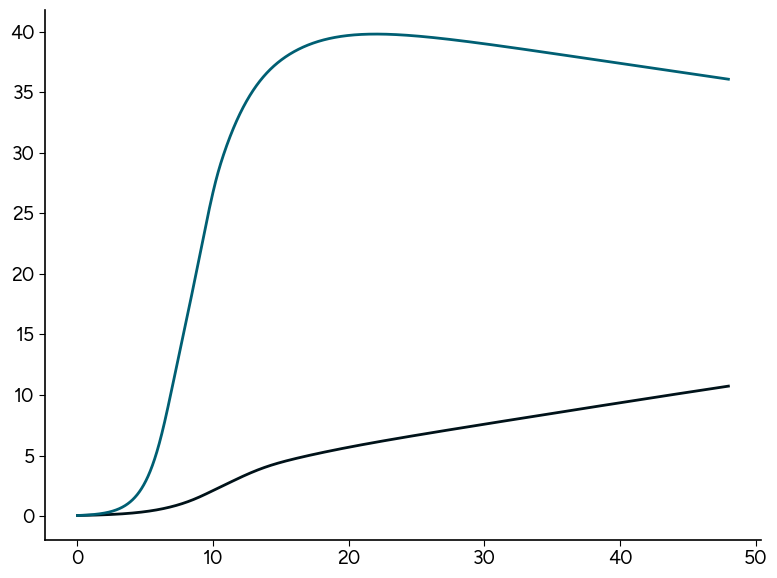

In [171]:
plt.plot(chemostat_sol.t,chemostat_sol.y[:Ns].T)

# plt.yscale("log")
plt.show()

In [172]:
qssCvsT = np.zeros((len(chemostat_sol.t),Nr))
for i in range(len(chemostat_sol.t)):
    curPop = chemostat_sol.y[:Ns,i]
    curRes = chemostat_sol.y[Ns:,i]
    currQssSol = cmpfns.qssResourcesSolver(cmpfns.resUsage,curPop,muMatrix, kMatrix, delta, supplyVec,Nr,Ns)
    qssCvsT[i] = currQssSol

tdepGrowth,tdepInter = np.zeros((len(chemostat_sol.t),Ns)),np.zeros((len(chemostat_sol.t),Ns,Ns))

for i in range(len(chemostat_sol.t)):
    tdepGrowth[i],tdepInter[i] = cmpfns.glvParamsFn(muMatrix,kMatrix,qssCvsT[i],delta,supplyVec,Nr,Ns)

KeyboardInterrupt: 

Text(0, 0.5, 'Interaction strength')

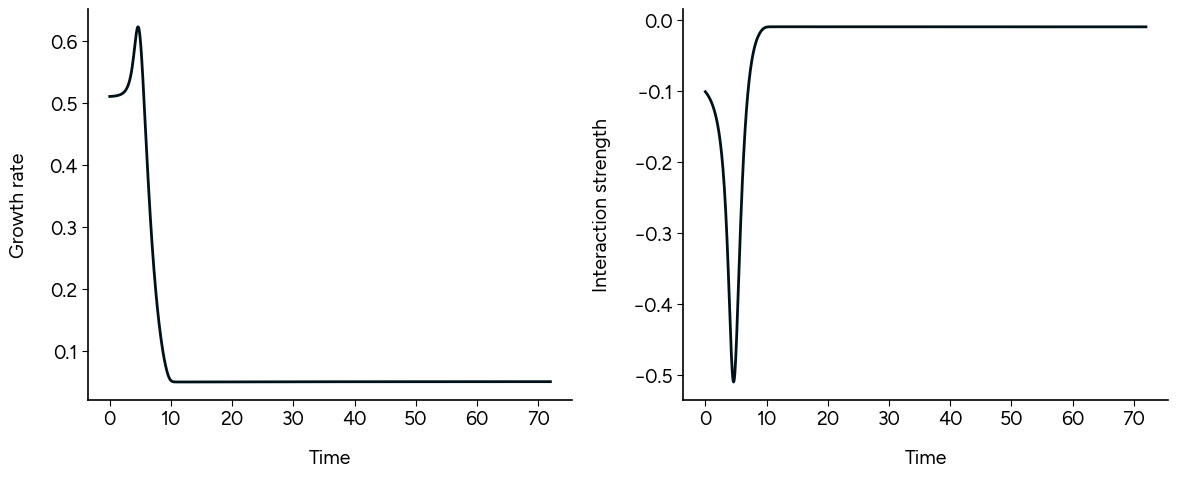

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(chemostat_sol.t,tdepGrowth)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Growth rate")

ax[1].plot(chemostat_sol.t,-tdepInter[:,0])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Interaction strength")

In [ ]:
glv_soln = cmpfns.solveTimeDepGLV(initialPopulations,t,tdepGrowth,tdepInter)

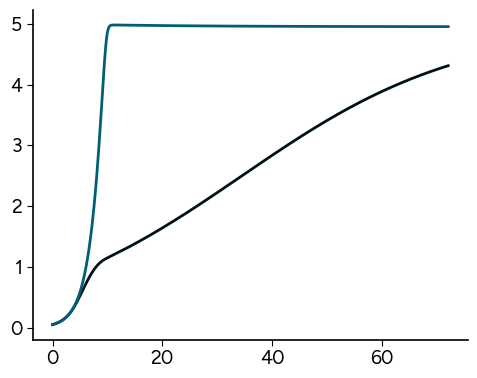

In [ ]:
fig,ax = plt.subplots(figsize=(5,4))
ax.plot(t,glv_soln.T)
ax.plot(t,chemostat_sol.y[:Ns].T)
plt.show()

## Multiple species Multiple resources

In [411]:
Nr = 40
Ns = 8

In [412]:
unscaledMuMatrix = np.random.lognormal(-1.95,1,(Ns,Nr))
muMatrix =  np.round(unscaledMuMatrix / np.max(unscaledMuMatrix) *0.6,3)

kMatrix = np.round(np.random.lognormal(5.5, 1.2,(Ns,Nr))/10,3)

supplyVec = np.full(Nr,5)
delta = 0.05

cmpfns.assertParams(muMatrix,kMatrix,delta,supplyVec,Ns=Ns,Nr=Nr)
rVecBeginning = supplyVec.copy()

In [413]:
initialPopulations = np.full(Ns,0.05)
initialResources = supplyVec
initialConditions = np.concatenate((initialPopulations,initialResources))

t = np.linspace(0,480,1000)

In [414]:
chemostat_sol = integrate.solve_ivp(cmpfns.chemostat_dynamics,(0,t[-1]),initialConditions,args=(muMatrix, kMatrix, delta, supplyVec,Nr,Ns),t_eval=t,max_step=0.1)

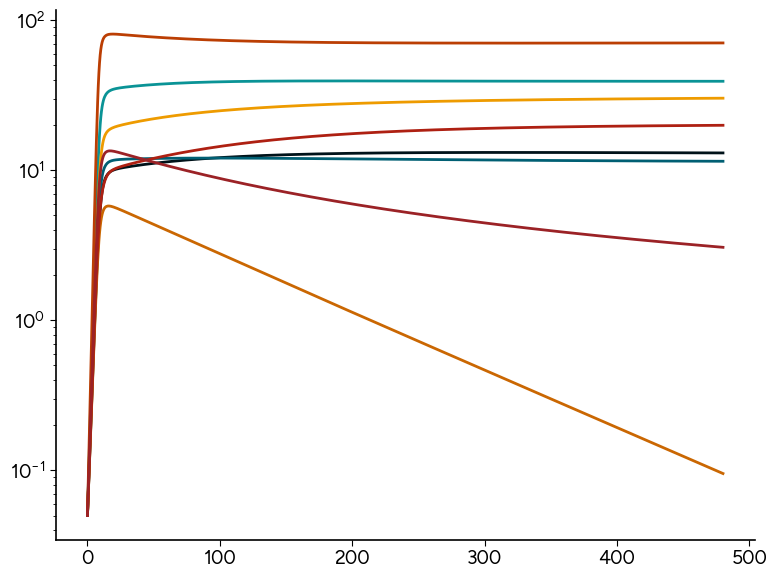

In [415]:
plt.plot(chemostat_sol.t,chemostat_sol.y[:Ns].T)

plt.yscale("log")
plt.show()

In [382]:
qssCvsT = np.zeros((len(chemostat_sol.t),Nr))
for i in range(len(chemostat_sol.t)):
    curPop = chemostat_sol.y[:Ns,i]
    curRes = chemostat_sol.y[Ns:,i]
    currQssSol = cmpfns.qssResourcesSolver(cmpfns.resUsage,curPop,curRes,muMatrix, kMatrix, delta, supplyVec,Nr,Ns)
    qssCvsT[i] = currQssSol

tdepGrowth,tdepInter = np.zeros((len(chemostat_sol.t),Ns)),np.zeros((len(chemostat_sol.t),Ns,Ns))

for i in range(len(chemostat_sol.t)):
    tdepGrowth[i],tdepInter[i] = cmpfns.glvParamsFn(muMatrix,kMatrix,qssCvsT[i],delta,supplyVec,Nr,Ns)

In [ ]:
# # Plotting QSS and chemostat resource concentrations

# fig,ax = plt.subplots(figsize=(8,6))
# for i in range(Nr):
#     ax.plot(chemostat_sol.t,qssCvsT[:,i],ls = "--",color=f"C{i}")
#     ax.plot(chemostat_sol.t,chemostat_sol.y[Ns+i],color=f"C{i}")
# plt.show()

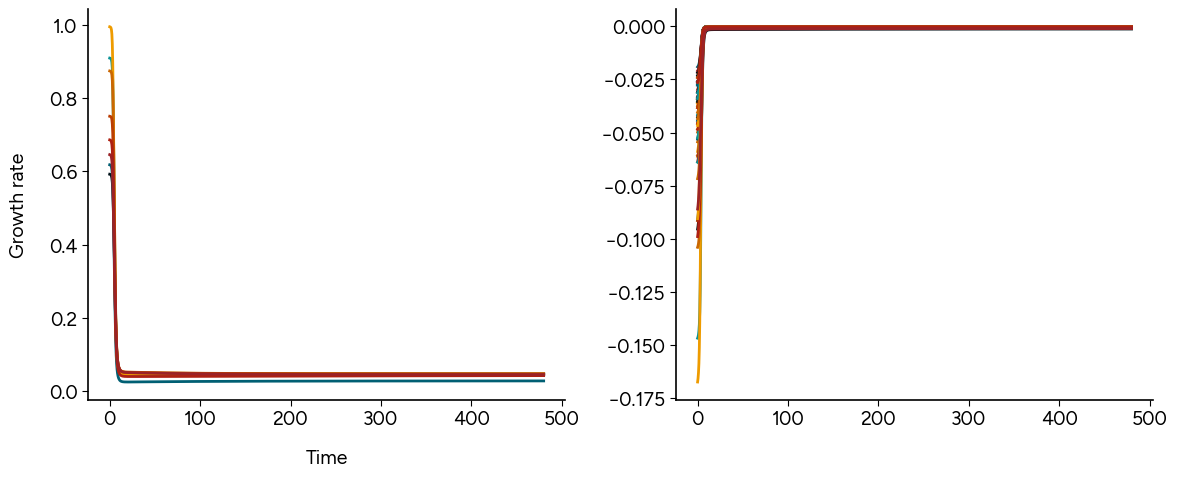

In [383]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(chemostat_sol.t,tdepGrowth)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Growth rate")

ax[1].plot(chemostat_sol.t,-tdepInter.reshape(len(chemostat_sol.t),Ns*Ns))
# ax[1].set_xlabel("Time")
# ax[1].set_ylabel("Interaction strength")
plt.show()

In [396]:
glv_soln_context_dep = cmpfns.solveTimeDepGLV(initialPopulations,t,tdepGrowth,tdepInter)
glv_soln_final_interactions = cmpfns.solveGLV(initialPopulations,t,tdepGrowth[-1],tdepInter[-1])

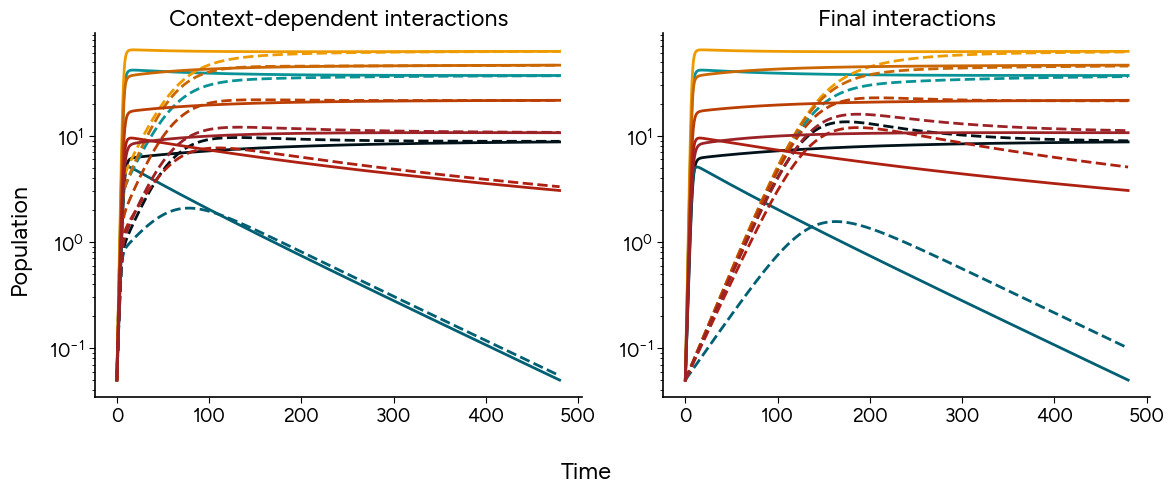

In [397]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
for i in range(Ns):
    ax[0].plot(t,glv_soln_context_dep[i],ls="--",color=f"C{i}")
    ax[0].plot(t,chemostat_sol.y[i],color=f"C{i}")
    ax[1].plot(t,glv_soln_final_interactions[i],ls="--",color=f"C{i}")
    ax[1].plot(t,chemostat_sol.y[i],color=f"C{i}")
ax[0].set_yscale("log")
ax[1].set_yscale("log")

ax[0].set_title("Context-dependent interactions")
ax[1].set_title("Final interactions")

fig.supxlabel("Time")
fig.supylabel("Population")

plt.show()

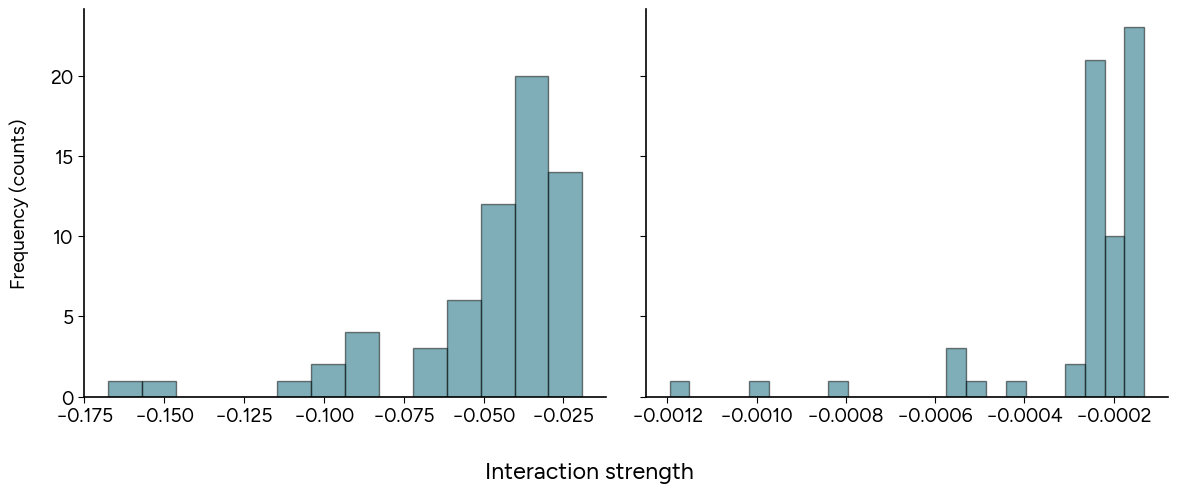

In [398]:
fig,ax = plt.subplots(1,2,figsize=(12,5),sharey=True)

ax[0].hist(-tdepInter[0].flatten(),bins="auto",density=False,facecolor="C1",alpha=0.5,edgecolor="black")
ax[1].hist(-tdepInter[-1].flatten(),bins="auto",density=False,facecolor="C1",alpha=0.5,edgecolor="black")

ax[0].set_ylabel("Frequency (counts)")

fig.supxlabel("Interaction strength")
plt.show()


In [416]:
qssCBegin = cmpfns.qssResourcesSolver(cmpfns.resUsage,initialPopulations,initialResources,muMatrix, kMatrix, delta, supplyVec,Nr,Ns)
qssCEnd = cmpfns.qssResourcesSolver(cmpfns.resUsage,chemostat_sol.y[:Ns,-1],chemostat_sol.y[Ns:,-1],muMatrix, kMatrix, delta, supplyVec,Nr,Ns)

tdepGrowthBegin,tdepInterBegin = cmpfns.glvParamsFn(muMatrix,kMatrix,qssCBegin,delta,supplyVec,Nr,Ns)
tdepGrowthEnd,tdepInterEnd = cmpfns.glvParamsFn(muMatrix,kMatrix,qssCEnd,delta,supplyVec,Nr,Ns)

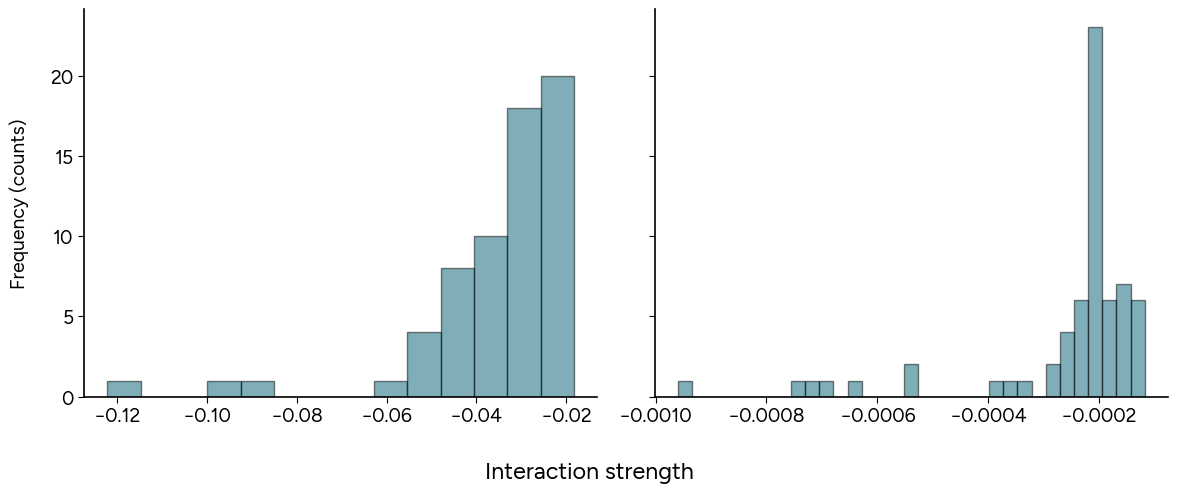

In [417]:
fig,ax = plt.subplots(1,2,figsize=(12,5),sharey=True)

ax[0].hist(-tdepInterBegin.flatten(),bins="auto",density=False,facecolor="C1",alpha=0.5,edgecolor="black")
ax[1].hist(-tdepInterEnd.flatten(),bins="auto",density=False,facecolor="C1",alpha=0.5,edgecolor="black")

ax[0].set_ylabel("Frequency (counts)")

fig.supxlabel("Interaction strength")
plt.show()


In [418]:
qssCBegin = cmpfns.qssResourcesSolver(cmpfns.resUsage,initialPopulations,initialResources,muMatrix, kMatrix, delta, supplyVec,Nr,Ns)
qssCEnd = cmpfns.qssResourcesSolver(cmpfns.resUsage,chemostat_sol.y[:Ns,-1],chemostat_sol.y[Ns:,-1],muMatrix, kMatrix, delta, supplyVec,Nr,Ns)

tdepGrowthBegin,tdepInterBegin = cmpfns.glvParamsFn(muMatrix,kMatrix,qssCBegin,delta,supplyVec,Nr,Ns)
tdepGrowthEnd,tdepInterEnd = cmpfns.glvParamsFn(muMatrix,kMatrix,qssCEnd,delta,supplyVec,Nr,Ns)

In [419]:
histbegin,edgesbegin = np.histogram(tdepInterBegin.flatten(),bins="auto",density=False)
histend,edgesend = np.histogram(tdepInterEnd.flatten(),bins="auto",density=False)

cumhistbegin = 1- np.cumsum(histbegin)/np.sum(histbegin)
cumhistend = 1-np.cumsum(histend)/np.sum(histend)

In [420]:
fitbegin = optimize.curve_fit(gamma_ccdf,edgesbegin[:-1],cumhistbegin)
fitend = optimize.curve_fit(gamma_ccdf,edgesend[:-1],cumhistend)

In [421]:
fitend[0]

array([5.98327888e+00, 3.34205552e-05])

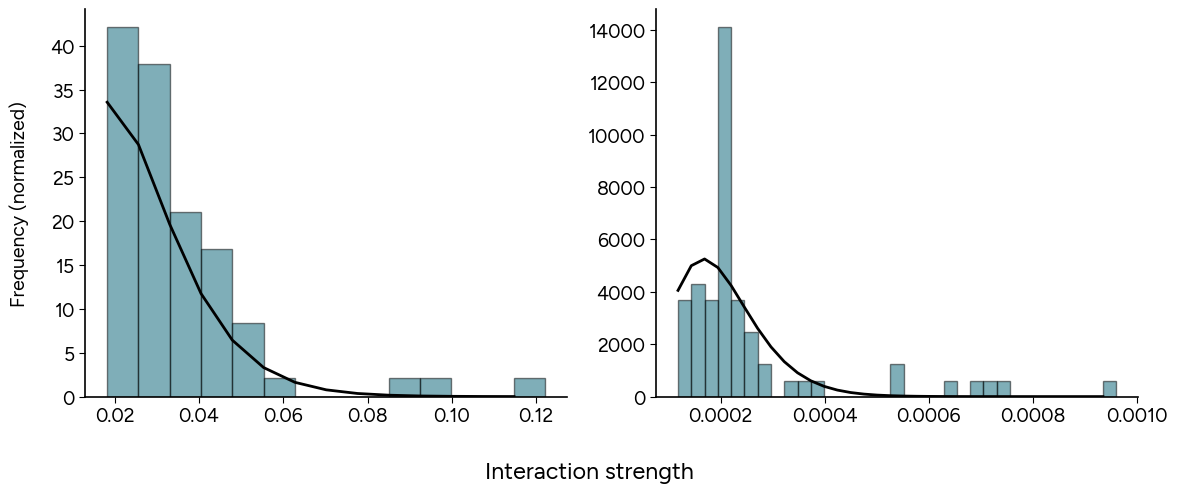

In [422]:
fig,ax = plt.subplots(1,2,figsize=(12,5),sharey=False)

ax[0].hist(tdepInterBegin.flatten(),bins="auto",density=True,facecolor="C1",alpha=0.5,edgecolor="black")
ax[0].plot(edgesbegin[:-1],gamma_fn(edgesbegin[:-1],*fitbegin[0]),color="black")
ax[1].hist((tdepInterEnd).flatten(),bins="auto",density=True,facecolor="C1",alpha=0.5,edgecolor="black")
ax[1].plot(edgesend[:-1],gamma_fn(edgesend[:-1],*fitend[0]),color="black")

ax[0].set_ylabel("Frequency (normalized)")

fig.supxlabel("Interaction strength")
plt.show()


In [409]:
fitend[0]

array([2.26509607e+00, 7.92726999e-05])

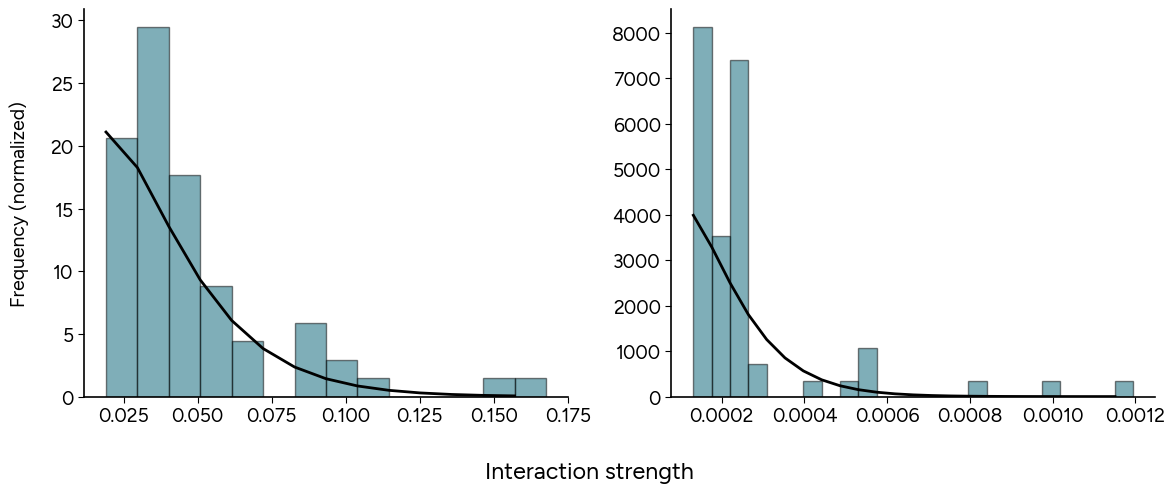

In [410]:
fig,ax = plt.subplots(1,2,figsize=(12,5),sharey=False)

ax[0].hist(tdepInterBegin.flatten(),bins="auto",density=True,facecolor="C1",alpha=0.5,edgecolor="black")
ax[0].plot(edgesbegin[:-1],gamma_fn(edgesbegin[:-1],*fitbegin[0]),color="black")
ax[1].hist((tdepInterEnd).flatten(),bins="auto",density=True,facecolor="C1",alpha=0.5,edgecolor="black")
ax[1].plot(edgesend[:-1],gamma_fn(edgesend[:-1],*fitend[0]),color="black")

ax[0].set_ylabel("Frequency (normalized)")

fig.supxlabel("Interaction strength")
plt.show()


In [21]:
sys.path.append("../scripts/")
import competitive_scaling
import time

In [22]:
Nr = 40
Ns = 8

muMean,muSd = -1.95,1
kMean,kSd = 5.5,1.2

delta = 0.05
supplyVec = np.full(Nr,5)

In [23]:
numRuns = 1

In [25]:
TSTART = time.time()
fitResults,fitErrors = competitive_scaling.multipleRun(Nr,Ns,supplyVec,delta,muMean,muSd,kMean,kSd,numRuns)
print(time.time()-TSTART)

14.550875663757324


In [26]:
fitResults,fitErrors

(array([[1.9323073e+00, 8.7983732e-05]]),
 array([[[ 1.60282039e-01, -7.46249000e-06],
         [-7.46249000e-06,  3.64153828e-10]]]))

In [16]:
np.mean(fitResults[:,0]),np.std(fitResults[:,0])

(2.007247537172612, 1.0864527382108102)

In [17]:
np.mean(fitResults[:,1]),np.std(fitResults[:,1])

(0.00011475398653219798, 4.499222863444643e-05)